In [1]:
import os
import glob
from math import ceil

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg

%load_ext autoreload
%autoreload 2

In [2]:
results_dir = os.path.join(
    cfg.repo_root, '08_cell_line_prediction', 'results', 'tcga_ccle_nn_hsize_range'
)

num_genes = 8000
seed = 42
plot_gene = 'KRAS'

In [3]:
hsize_dfs = {}

for hsize_file in glob.glob(
    os.path.join(results_dir,
                 plot_gene,
                 f'{plot_gene}_signal_mad_s{seed}_n{num_genes}_h*_classify_learning_curves.tsv.gz')
):
    hsize = (
        os.path.basename(hsize_file).split('_')[5].replace('h', '')
    )
    hsize_df = pd.read_csv(hsize_file, sep='\t', index_col=0).reset_index(drop=True)
    hsize_df['hsize'] = hsize
    hsize_dfs[hsize] = hsize_df

print(sorted(list(hsize_dfs.keys())))
hsize_dfs[list(hsize_dfs.keys())[0]].head()

['1', '10', '100', '1000', '2', '3', '4', '5', '50', '500']


,epoch,fold,dataset,metric,value,hsize
0,1,0,train,aupr,0.468339,5
1,2,0,train,aupr,0.567901,5
2,3,0,train,aupr,0.592309,5
3,4,0,train,aupr,0.662504,5
4,5,0,train,aupr,0.663414,5


[1, 2, 3, 4, 5, 10, 50, 100, 500, 1000]


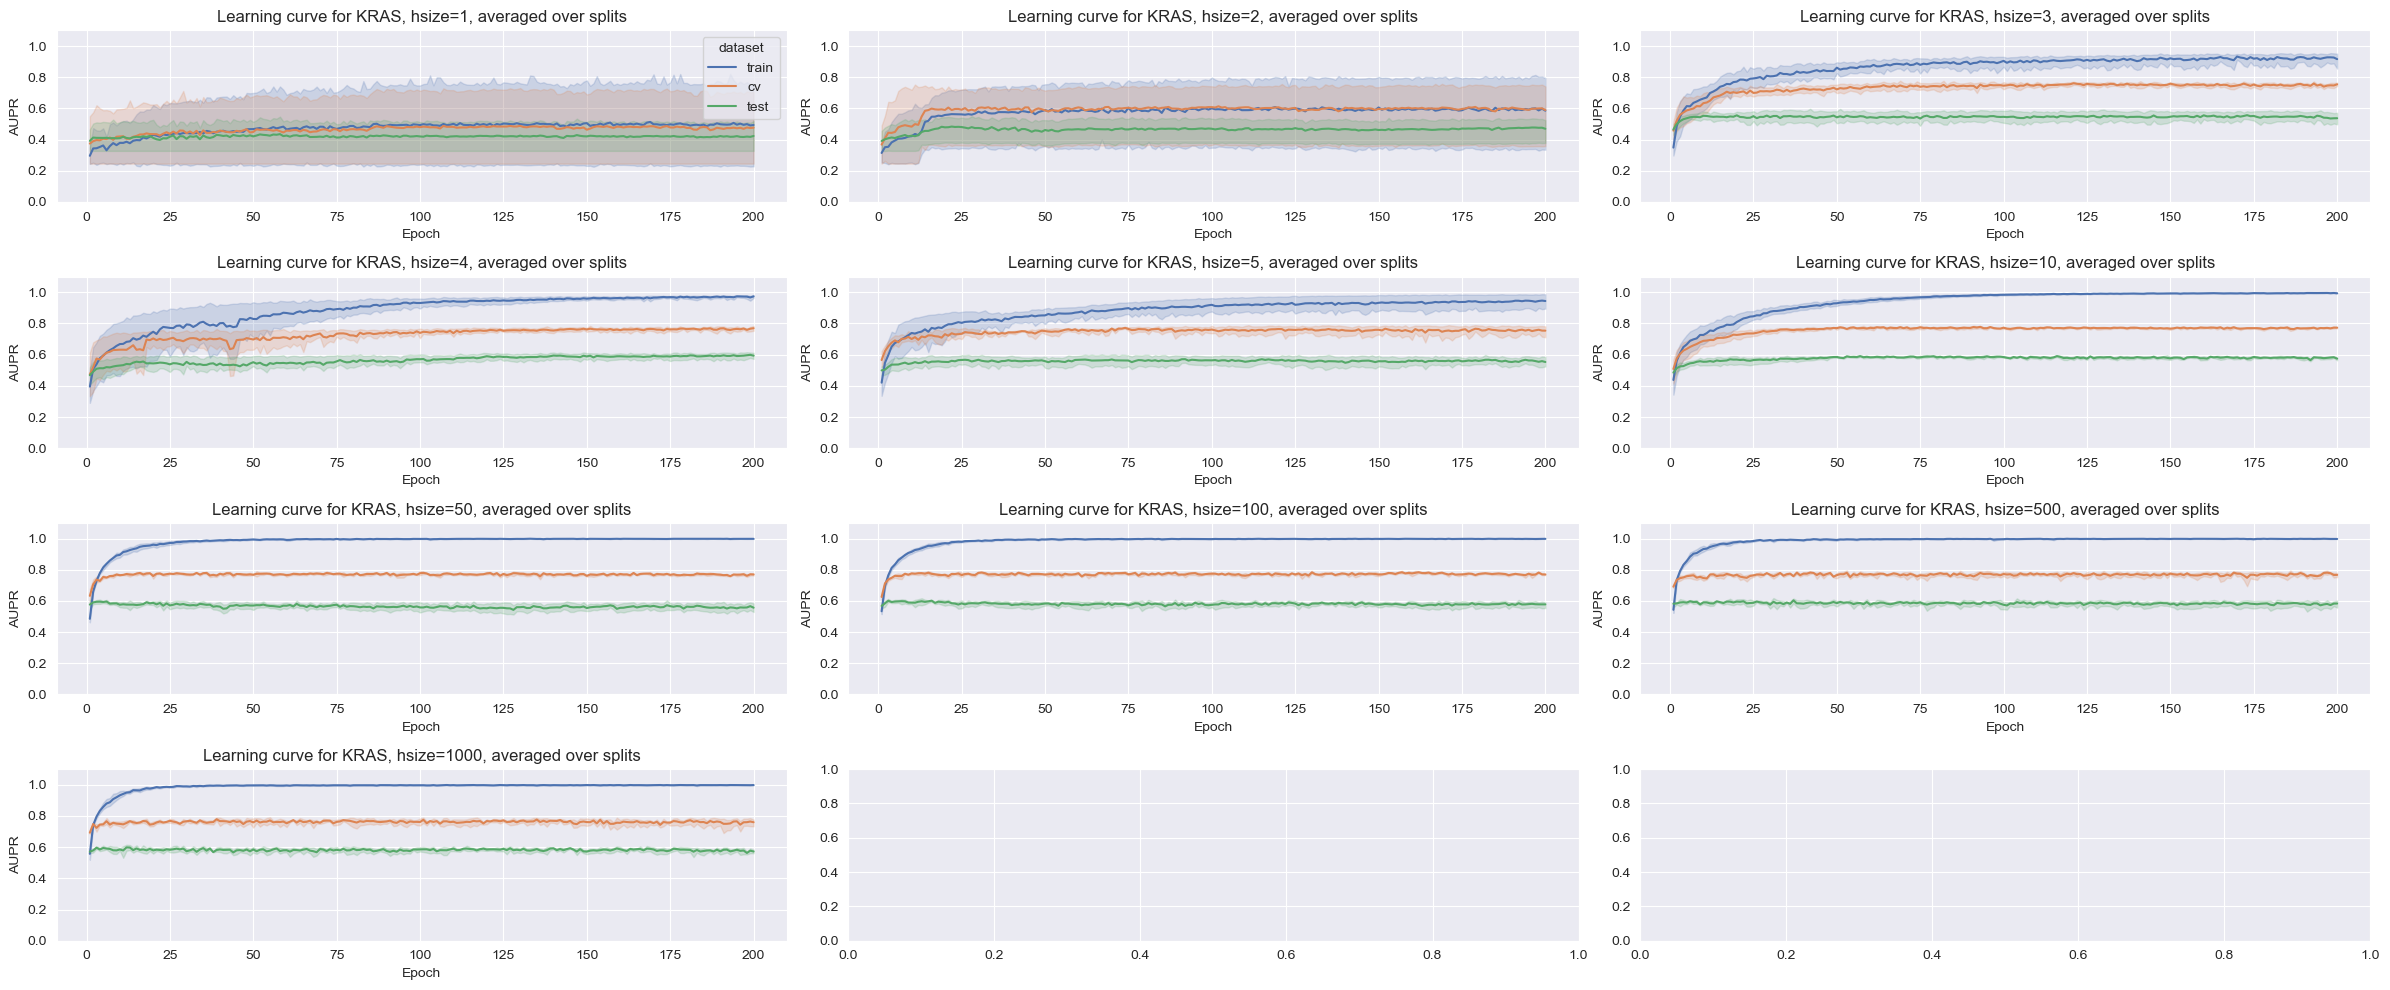

In [4]:
sns.set_style('whitegrid')
sns.set({'figure.figsize': (24, 10)})

hsize_vals = sorted(list([int(k) for k in hsize_dfs.keys()]))
print(hsize_vals)

fig, axarr = plt.subplots(ceil(len(hsize_vals) / 3), 3)

for ix, hsize in enumerate(hsize_vals):
    ax = axarr[ix // 3, ix % 3]
    if ix == 0:
        sns.lineplot(data=hsize_dfs[str(hsize)], x='epoch', y='value', hue='dataset', ax=ax)
    else:
        sns.lineplot(data=hsize_dfs[str(hsize)], x='epoch', y='value', hue='dataset', legend=False, ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('AUPR')
    ax.set_ylim(0, 1.1)
    ax.set_title(f'Learning curve for {plot_gene}, hsize={hsize}, averaged over splits')
    
plt.tight_layout()

[1, 2, 3, 4, 5, 10, 50, 100, 500, 1000]


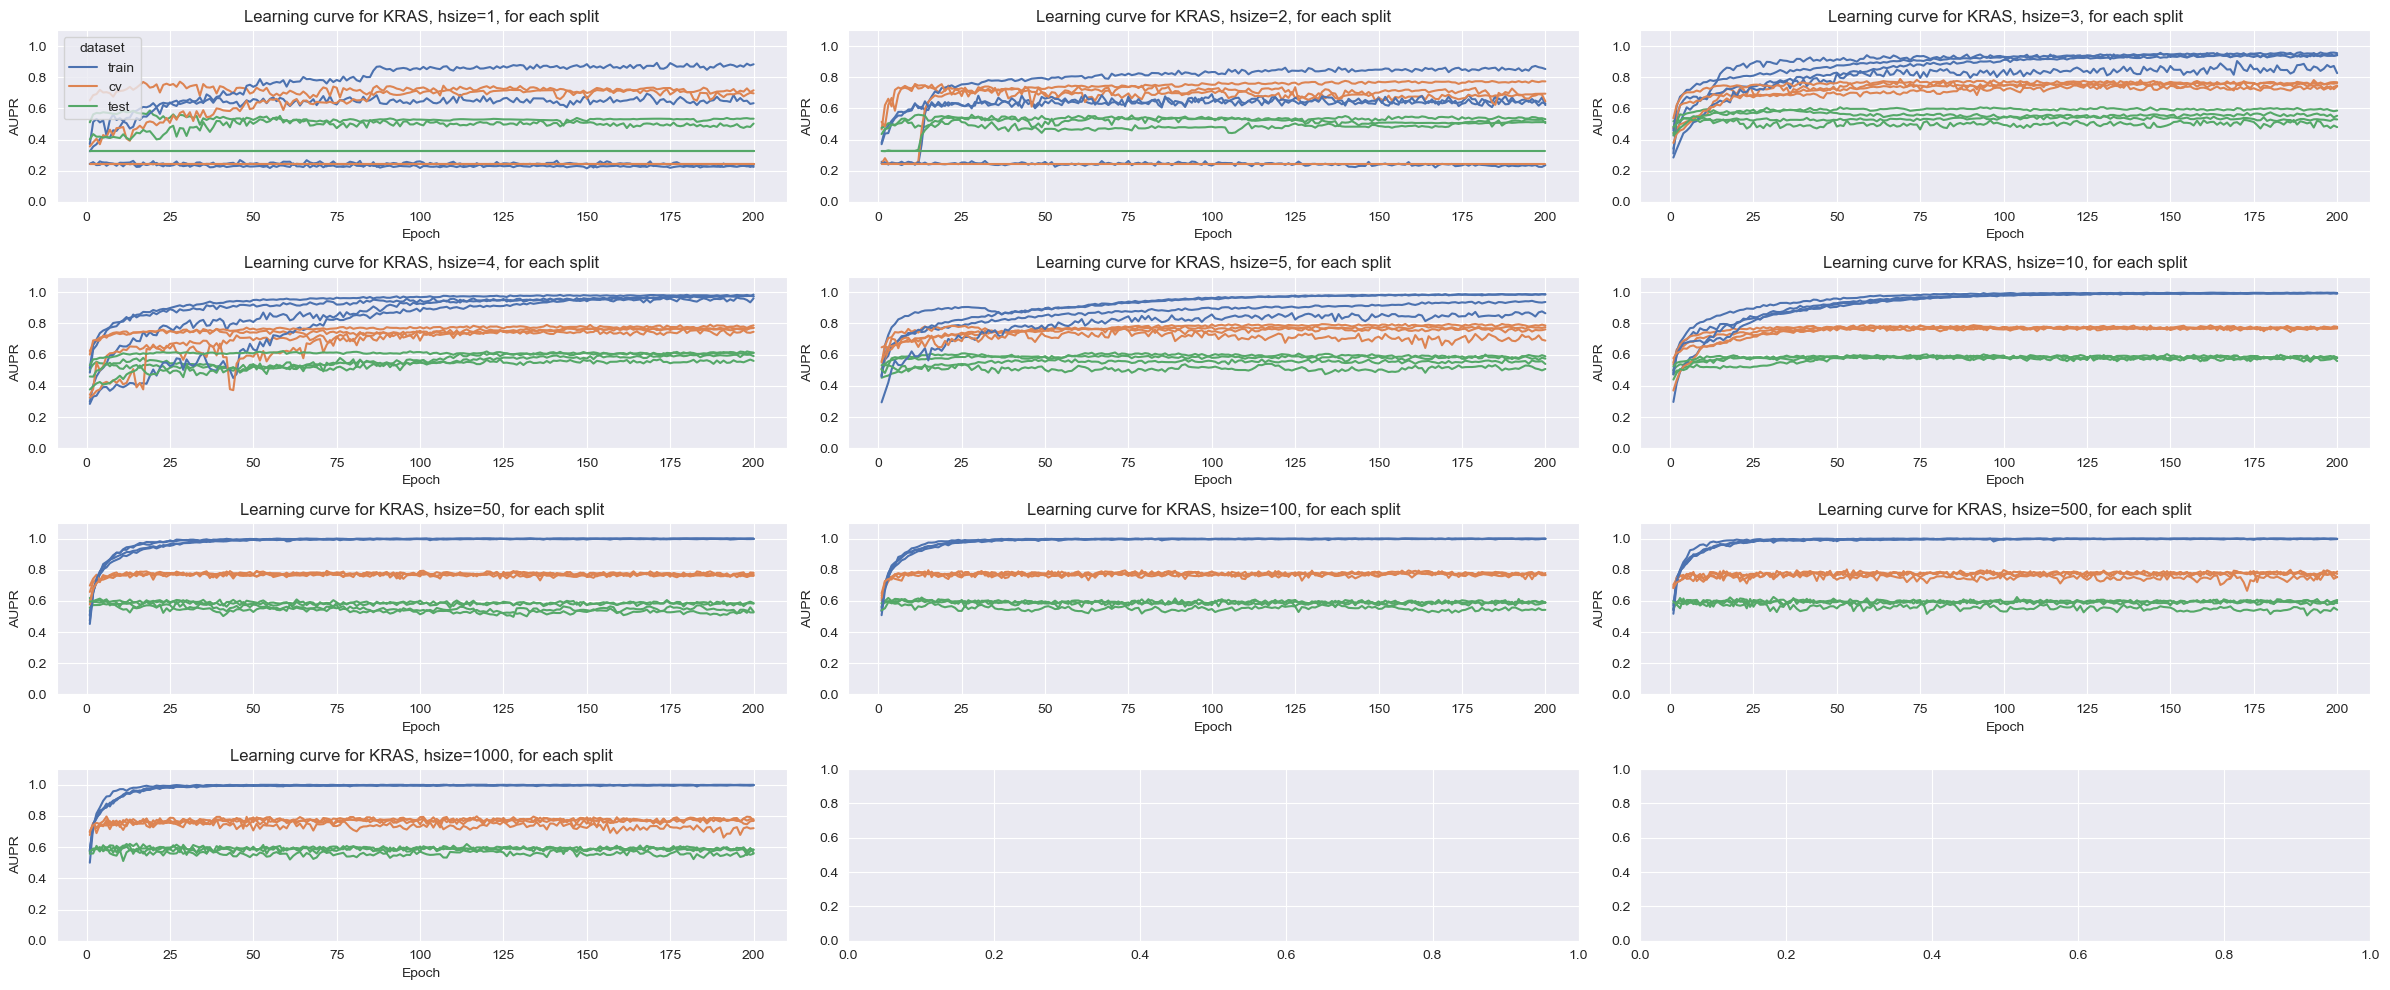

In [5]:
sns.set_style('whitegrid')
sns.set({'figure.figsize': (24, 10)})

hsize_vals = sorted(list([int(k) for k in hsize_dfs.keys()]))
print(hsize_vals)

fig, axarr = plt.subplots(ceil(len(hsize_vals) / 3), 3)

for hsize_ix, hsize in enumerate(hsize_vals):
    ax = axarr[hsize_ix // 3, hsize_ix % 3]
    hsize_df = hsize_dfs[str(hsize)]
    for fold_ix, fold in enumerate(hsize_df.fold.unique()):
        if hsize_ix == 0 and fold_ix == 0:
            sns.lineplot(data=hsize_df[hsize_df.fold == fold],
                         x='epoch', y='value', hue='dataset', ax=ax)
        else:
            sns.lineplot(data=hsize_df[hsize_df.fold == fold],
                         x='epoch', y='value', hue='dataset',
                         legend=False, ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('AUPR')
    ax.set_ylim(0, 1.1)
    ax.set_title(f'Learning curve for {plot_gene}, hsize={hsize}, for each split')

plt.tight_layout()

In [6]:
hsize_df = pd.concat(hsize_dfs.values())
print(hsize_df.shape)
hsize_df.head()

(24000, 6)


,epoch,fold,dataset,metric,value,hsize
0,1,0,train,aupr,0.468339,5
1,2,0,train,aupr,0.567901,5
2,3,0,train,aupr,0.592309,5
3,4,0,train,aupr,0.662504,5
4,5,0,train,aupr,0.663414,5


In [7]:
last_epoch = hsize_df.epoch.max()
perf_df = (hsize_df[hsize_df.epoch == last_epoch]
    .drop(columns=['epoch'])
)
                      
print(perf_df.shape)
perf_df.head()

(120, 5)


,fold,dataset,metric,value,hsize
199,0,train,aupr,0.937644,5
399,0,cv,aupr,0.775959,5
599,0,test,aupr,0.540191,5
799,1,train,aupr,0.985114,5
999,1,cv,aupr,0.761963,5


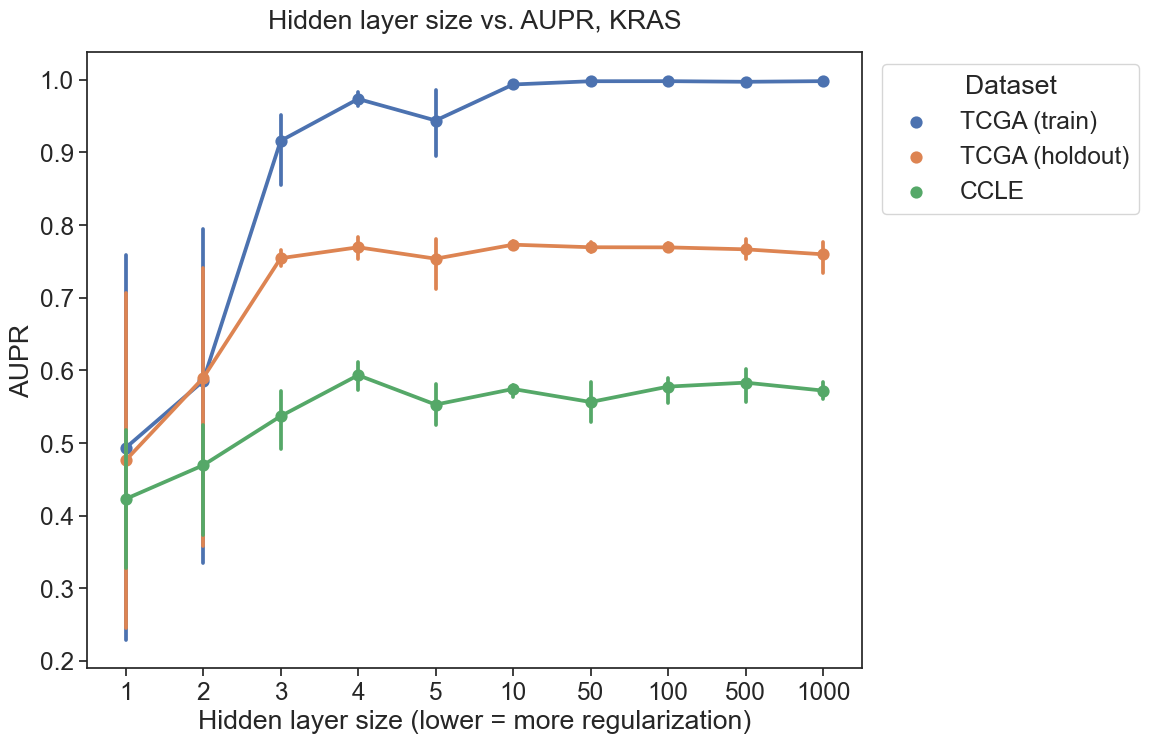

In [8]:
# plot hidden layer size as a categorical variable vs. performance
sns.set({'figure.figsize': (10, 8)})
sns.set_style('ticks')

plot_df = (perf_df
    .sort_values(by=['hsize'])
    .reset_index(drop=True)
)
plot_df.hsize = plot_df.hsize.astype(int)

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.pointplot(
        data=plot_df,
        x='hsize', y='value', hue='dataset',
        hue_order=['train', 'cv', 'test'],
        marker='o'
    )
    g.set_xlabel(f'Hidden layer size (lower = more regularization)')
    g.set_ylabel('AUPR')
        
    ax = plt.gca()
    legend_handles, _ = ax.get_legend_handles_labels()
    dataset_labels = ['TCGA (train)', 'TCGA (holdout)', 'CCLE'] 
    ax.legend(legend_handles, dataset_labels, title='Dataset')
    sns.move_legend(g, "upper left", bbox_to_anchor=(1.01, 1))
    plt.title(f'Hidden layer size vs. AUPR, {plot_gene}', y=1.025)

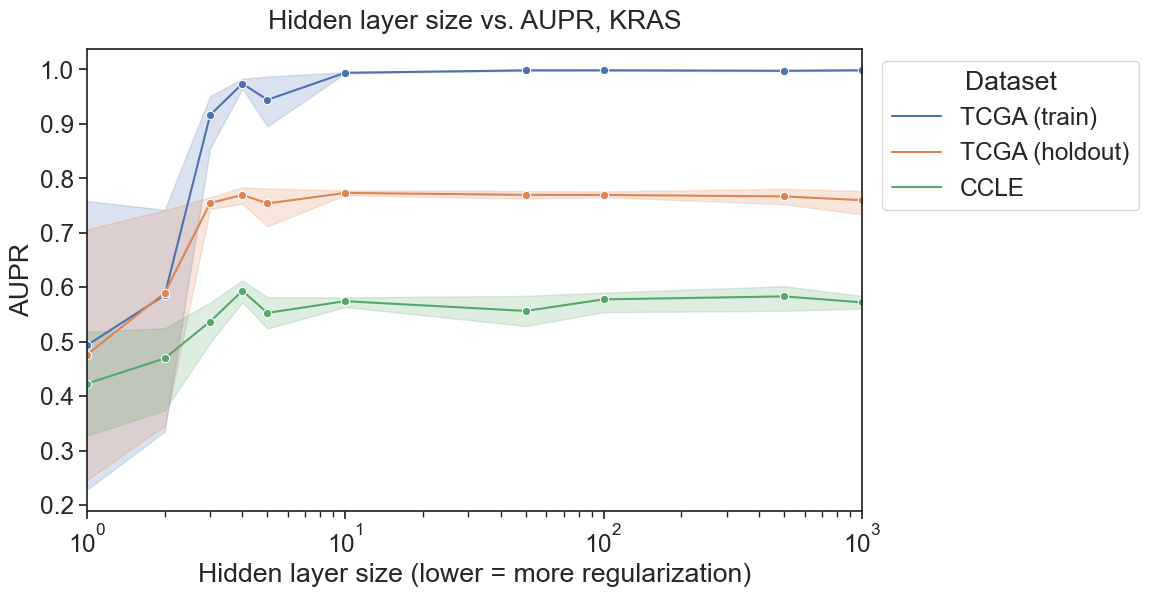

In [9]:
# plot hidden layer size as a float-valued variable (on a log scale) vs. performance
sns.set({'figure.figsize': (10, 6)})
sns.set_style('ticks')

plot_df = (perf_df
    .sort_values(by=['hsize'])
    .reset_index(drop=True)
)
plot_df.hsize = plot_df.hsize.astype(int)

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.lineplot(
        data=plot_df,
        x='hsize', y='value', hue='dataset',
        hue_order=['train', 'cv', 'test'],
        marker='o'
    )
    g.set(xscale='log', xlim=(min(plot_df.hsize), max(plot_df.hsize)))
    g.set_xlabel(f'Hidden layer size (lower = more regularization)')
    g.set_ylabel('AUPR')
        
    ax = plt.gca()
    legend_handles, _ = ax.get_legend_handles_labels()
    dataset_labels = ['TCGA (train)', 'TCGA (holdout)', 'CCLE'] 
    ax.legend(legend_handles, dataset_labels, title='Dataset')
    sns.move_legend(g, "upper left", bbox_to_anchor=(1.01, 1))
    plt.title(f'Hidden layer size vs. AUPR, {plot_gene}', y=1.025)